In [265]:
# imports
import genData
import importlib
importlib.reload(module=genData)

import torch
from torch.utils.data import DataLoader
from torch import nn

%matplotlib ipympl
import matplotlib.pyplot as plt

In [280]:
# first is function that generates the data, second is number of dimensions
InputShape = {
    'CIRCLESINCIRCLE': (genData.spheresInSphere2D, 2),
    'INTERLOCKINGTORI': (genData.interlockingTori, 3),
    'SPHERELAYERS': (genData.sphereInSphereInSphere, 3)
    }

### Start Here
Interact with the program by selecting your input shape from the three options above, changing your NN_SHAPE, and then running all. See your graphs at the bottom.

In [281]:
# variables

# choose input shape
INPUT_SHAPE = InputShape['SPHERELAYERS']

# choose neural network hyperparameters
NN_SHAPE = [30] * 10 # list of number of dimensions in each hidden layer
BATCH_SIZE = 50 # for stochastic gradient descent
EPOCHS = 10 # training epochs, can easily change later to make it go until loss is negligible

# choose size of training and testing data
TRAIN_POINTS = 50000
TEST_POINTS = 10000


In [282]:
D = INPUT_SHAPE[1]

# train and test datasets
# train_pts = torch.tensor(, dtype=torch.float)
# test_pts = torch.tensor(, dtype=torch.float)
train = genData.TopologicalDataset(INPUT_SHAPE[0](TRAIN_POINTS))
test = genData.TopologicalDataset(INPUT_SHAPE[0](TEST_POINTS))

# dataloader
loader = DataLoader(train, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test, batch_size=BATCH_SIZE, shuffle=True)

In [283]:
# nueral network class
class Classifier(nn.Module):

    def __init__(self, layers): # where layers has the number of dimensions of each layer at each index, the first being the dimensions of the input
        super().__init__()
        # build a list with all the functions data passes through in order
        # note that layers are actually functions
        self.seqlist = nn.ParameterList()
        for l in range(len(layers)-1):
            self.seqlist.append(nn.Linear(layers[l], layers[l+1]))
            self.seqlist.append(nn.ReLU())
        self.seqlist.append(nn.Linear(layers[len(layers)-1], 1)) # output
        self.seqlist.append(nn.Sigmoid())
        self.numlayers = len(layers) # including input but not output

    def forward(self, x):
        for function in self.seqlist:
            x = function(x)
        return x.reshape(len(x))

    # where x is the data and y is the known labels
    def plot(self, x, y):

        colormap = ['blue','red']
        colors = [colormap[i] for i in y.type(torch.int)]

        for l in range(0, len(self.seqlist), 2):
            data = x.detach() # makes data usable by taking of gradient
            x = self.seqlist[l+1](self.seqlist[l](x))
            n = int(l/2)

            # pca without really understanding it :(
            #print(torch.pca_lowrank(data)[2][:, :3])
            print((torch.pca_lowrank(data)[1] ** 2)/(data.size()[0]-1))
            data = torch.matmul(data, torch.pca_lowrank(data)[2][:, :3])

            if data.size()[1] == 3:
                ax = plt.figure().add_subplot(projection='3d')
                ax.scatter(data[:,0], data[:,1], data[:,2], s=12, c=colors)
                ax.view_init(elev=0, azim=-35, roll=0)

            elif data.size()[1] == 2:
                ax = plt.figure().add_subplot(projection=None)
                ax.scatter(data[:,0], data[:,1], s=12, c=colors)

            ax.axis("equal")
            ax.set_title('layer #' + str(n))

        plt.show()

        return nn.Sigmoid()(x).reshape(len(x))


### Modify Here
Play around with the hyperparameters as you see fit.

In [294]:
# choose hyperparameters here again so you don't have to load data every time to try things out
NN_SHAPE = NN_SHAPE # list of number of dimensions in each hidden layer
BATCH_SIZE = BATCH_SIZE # for stochastic gradient descent
EPOCHS = EPOCHS # training epochs, can easily change later to make it go until loss is negligible

In [295]:
# training neural network

net = Classifier([D] + NN_SHAPE)
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)
loss_function = nn.BCELoss() # binary cross-entropy

for epoch in range(EPOCHS):
    net.train() # just puts it in training mode
    for batch in loader:
        x, y = batch
        y = y.type(torch.float32)
        net.zero_grad()
        output = net(x)
        loss = loss_function(output, y) 
        loss.backward() # magic
        optimizer.step() # adjusts weights
    print(loss)


tensor(3.3301e-06, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(5.7415e-07, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(3.6933e-07, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(2.1081e-07, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(6.5942e-08, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(3.8973e-08, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.7880e-08, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(6.3986e-09, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(1.0363e-09, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(3.7241e-09, grad_fn=<BinaryCrossEntropyBackward0>)


In [296]:
# evaluate the network

net.eval()
correct = 0
total = 0

with torch.no_grad(): # tells pytorch your not calculating gradients so reduces memory consumption
    for data in test_loader:
        x, y = data
        output = net(x)
        for idx, i in enumerate(output): # enumerate lets you go over something by index and by actual object
            if torch.round(i, decimals=0) == y[idx]: # torch.argmax returns the index of the max value in the tensor
                correct += 1
            total += 1

print('Accuracy: ', round(correct/total, 3))


Accuracy:  1.0


tensor([0.1763, 0.1716, 0.1561])
tensor([0.2942, 0.1957, 0.1440, 0.0396, 0.0339, 0.0215])
tensor([0.3823, 0.0675, 0.0277, 0.0126, 0.0071, 0.0057])
tensor([5.6509e+00, 4.9985e-02, 4.9569e-02, 1.5837e-02, 3.8457e-03, 2.3182e-03])
tensor([3.2305e+01, 7.1771e+00, 2.5181e-01, 4.3153e-03, 1.7802e-03, 9.8407e-04])
tensor([1.8101e+02, 5.4932e+01, 6.4230e-01, 4.3043e-03, 1.6842e-03, 4.4907e-04])


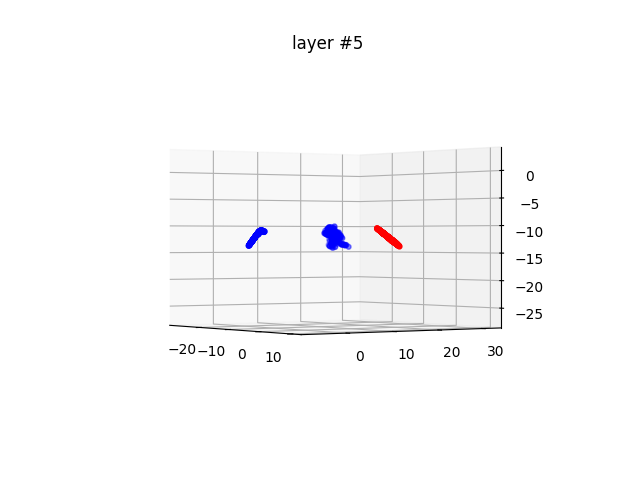

tensor([0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.7311, 0.5000, 0.5000, 0.5000,
        0.5000, 0.7311, 0.7311, 0.7311, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000,
        0.7311, 0.5000, 0.7311, 0.5000, 0.5000, 0.5000, 0.5000, 0.7311, 0.7311,
        0.7311, 0.5000, 0.7311, 0.7311, 0.5000, 0.7311, 0.7311, 0.5000, 0.7311,
        0.7311, 0.5000, 0.7311, 0.5000, 0.5000, 0.7311, 0.5000, 0.5000, 0.7311,
        0.5000, 0.7311, 0.5000, 0.5000, 0.5000, 0.7311, 0.5000, 0.5000, 0.7311,
        0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000,
        0.7311, 0.7311, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000,
        0.7311, 0.7311, 0.7311, 0.5000, 0.7311, 0.7311, 0.5000, 0.7311, 0.7311,
        0.5000, 0.5000, 0.7311, 0.7311, 0.5000, 0.5000, 0.5000, 0.5000, 0.7311,
        0.5000, 0.7311, 0.7311, 0.7311, 0.5000, 0.7311, 0.5000, 0.5000, 0.7311,
        0.7311, 0.7311, 0.5000, 0.7311, 0.7311, 0.5000, 0.5000, 0.7311, 0.5000,
        0.5000, 0.5000, 0.7311, 0.5000, 

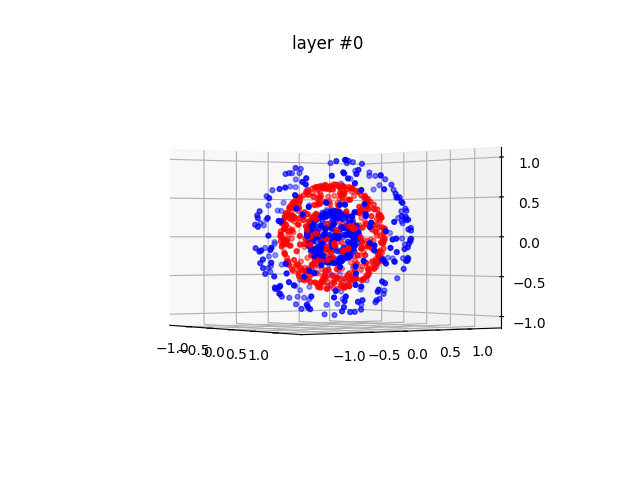

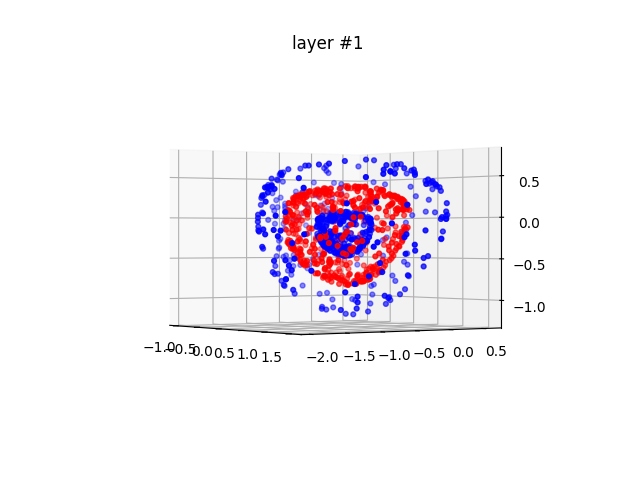

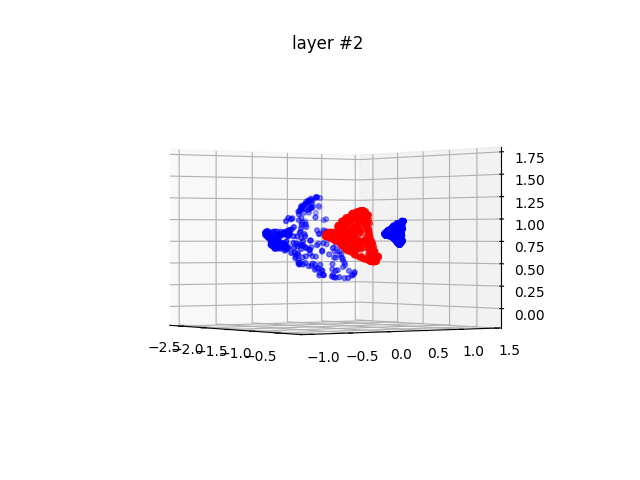

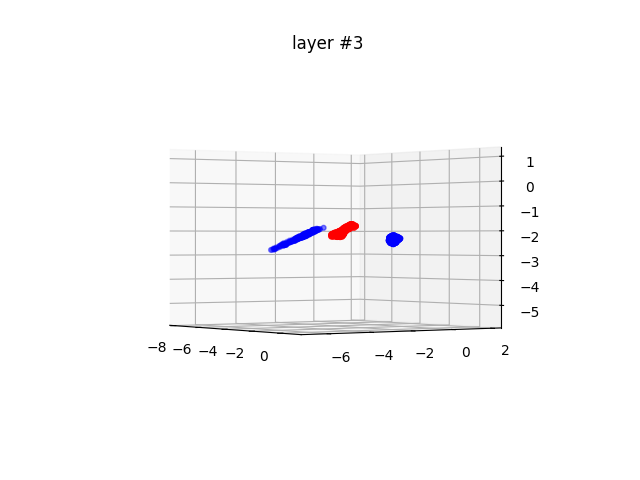

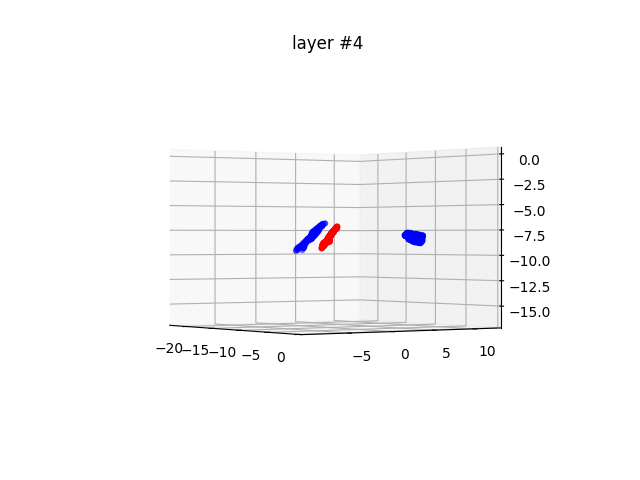

In [297]:
# see evolution of the topology
visualizationLoader = DataLoader(test, batch_size=1000, shuffle=True)
data = next(iter(visualizationLoader))
x, y = data
net.plot(x, y)